In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import math
import re
import networkx as nx
import csv

import matplotlib.pyplot as plt
import pickle
import os
import json

# imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
import pandas as pd
from community import community_louvain
import fa2
import random

import os
from IPython.display import clear_output 

save=False

In [3]:
spotify_df = pd.read_pickle("/content/drive/MyDrive/SocialGraphs/spotify_dataset_preprocessed.pickle")

We are using a subset of the [**#nowplaying**](https://dbis.uibk.ac.at/sites/default/files/2017-03/wissm03-zangerle.pdf) dataset. The #nowplaying dataset includes tracks which have been tweeted using the hashtags #nowplaying, #listento or #listeningto. 

The dataset which we are going to use holds users, their playlists and the tracks contained in these playlists. Our interest is just in the tracks what a particular user is listening to, so during the preprocesing phase, the `playlistname` column will be removed.

In [2]:
spotify_df = pd.read_csv('/content/drive/MyDrive/SocialGraphs/spotify_dataset.csv', 
                         skiprows=1,
                         names=['user_id', 'artistname', 'trackname', 'playlistname'],
                         on_bad_lines='skip')
spotify_df.dropna()

df_size = len(spotify_df)
print("Initial datase set size:", df_size)
spotify_df.head()

Initial datase set size: 12901979


,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


The `artistname` column contains the artist’s name extracted from the tweets with minimal preprocessing. Therefore, we should validate the column by checking if the values correspond to a single or multiple artists since a song can be performed by a single artist, multiple artists, or groups. 

We start with computing a set with all values of the `artistname`.

In [3]:
# generate initial artists set
artists_set = set(map(lambda artist: str(artist).lower(), spotify_df.artistname))
len(artists_set)

282712

The dataset contains 282712 unique values for the `artistname`. Now, we want to check how many of these values correspond to a single artist or it is about a collaboration. 

One problem with the dataset is how the names of artists who collaborated on the same song are delimited. Since there is not a standard deminitation, we split the `artistiname` using multiple delimitators: "&", ",",  "/", "and", "feat.", "ft.", "featuring", "with" and check if it is a true collaboration and not the name of an artistic group.

In [ ]:
i = 0
for idx, entry in spotify_df.iterrows():
    if i % 100000 == 0:
        print(i, "/", df_size)
    i+=1
    
    names = re.split('( and | & |, | \/ | feat. | feat | ft. | f. | featuring | with | - |; )', str(entry.artistname).lower())
    # check if it is a collaboration:
    if (set(names) & (artists_set)):
        # update the entry
        entry.artistname = list((set(names) & (artists_set)))
    else:
        entry.artistname = [str(entry.artistname).lower()]


In [5]:
spotify_df.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,{elvis costello},(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,{elvis costello},"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,{tiffany page},7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,{elvis costello},Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,{elvis costello},Alison,HARD ROCK 2010


In [6]:
# update artists set
artists_set = set([artist for artists in spotify_df.artistname for artist in artists])
len(artists_set)

241450

We want to know the popularity of each artist, based on the users sample. We compute the popularity as beeing the number of occuracies in the dataset.

In [7]:
# compute number of occurancies
popularity = Counter(x for xs in spotify_df.artistname for x in set(xs))
popularity.most_common(5)

[('daft punk', 36309),
 ('coldplay', 35626),
 ('nan', 33568),
 ('radiohead', 31467),
 ('the rolling stones', 30844)]

Display popularity distribution

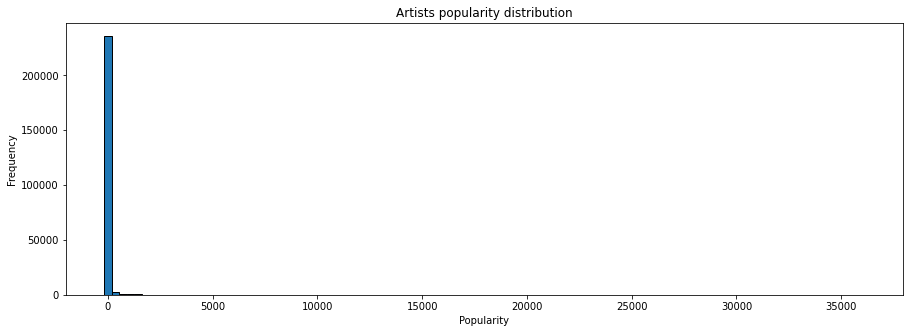

In [8]:
values = list(popularity.values())
hist, bin = np.histogram(values, bins=100) # return an array with histogram values and the bin edges 

plt.figure(figsize=(15, 5))
plt.title('Artists popularity distribution')
plt.bar(bin[:-1], hist, width=bin[1]-bin[0], ec='k', lw=1)
plt.xlabel("Popularity")
plt.ylabel("Frequency")

plt.show()

Since an artist has a very low number of occurancies in the dataset, we can remove them. Therefore, we removed all artists with a number of occurences lower than 500.

In [112]:
# spotify_df.to_pickle(r'/content/drive/MyDrive/SocialGraphs/spotify_dataset_small.pickle') 

In [18]:
artists_set = set([key for key, val in popularity.items() if val > 50])

In [19]:
remove_idx = []
i = 0
for idx, entry in spotify_df.iterrows():
    if i % 100000 == 0:
        # os.system('clear')
        clear_output()
        print(i, "/", len(spotify_df))
    i+=1
    if not set(entry.artistname).issubset(artists_set):
        remove_idx.append(idx)

spotify_df.drop(remove_idx, axis=0, inplace=True)
len(spotify_df)

12900000 / 12901979


11479711

### Create artists network

In [61]:
import networkx as nx
# construct artist network
artists_graph = nx.Graph()
artists_graph.add_nodes_from(artists_set)


We extract the collaborations from the spotify dataset, where we have a collaboration only if there are multiple entries in the list of artists associated with each track.

In [62]:
collaborations = spotify_df.loc[map(lambda artists: len(artists) > 1, spotify_df.artistname)]
len(collaborations)

221474

Each artist should de connected according to their collaborations.

In [63]:
i = 0
for _, entry in collaborations.iterrows():
    if i % 100000 == 0:
        # os.system('clear')
        clear_output()
        print(i, "/", len(collaborations))
    i+=1
    for a in range(len(entry.artistname) - 1):
        for b in range(a+1, len(entry.artistname)):
            artists_graph.add_edge(list(entry.artistname)[a], list(entry.artistname)[b])

200000 / 221474


### Artists' collaboration network

The next step is to remove the isolated nodes, the artists without collabortaions, and extracted the largest connected component.

In [64]:
artists_graph.remove_nodes_from(list(nx.isolates(artists_graph)))
Gcc = sorted(nx.connected_components(artists_graph), key=len, reverse=True)
artists_graph = artists_graph.subgraph(Gcc[0])

print("number of nodes:", artists_graph.number_of_nodes())
print("number of edges:", artists_graph.number_of_edges())

number of nodes: 4819
number of edges: 10418


Save the new spotify dataset

In [ ]:
remove_idx = []
i = 0
for idx, entry in spotify_df.iterrows():
    if i % 100000 == 0:
        # os.system('clear')
        clear_output()
        print(i, "/", len(spotify_df))
    i+=1
    if not set(entry.artistname).issubset(artists_set):
        remove_idx.append(idx)

spotify_df.drop(remove_idx, axis=0, inplace=True)

if save == True:
    spotify_df.to_pickle(r'/content/drive/MyDrive/SocialGraphs/spotify_dataset_preprocessed.pickle')

#### Get information from Spotify API

In [47]:
artists_set = set(artists_graph.nodes())
data = {'artistname': list(artists_set),
        'id': [None] * len(artists_set),
        'popularity': [None] * len(artists_set),
        'genres': [None] * len(artists_set),
        'related_artists': [None] * len(artists_set)}
artists_df = pd.DataFrame(data)

if save == True:
    artists_df.to_pickle(r'/content/drive/MyDrive/SocialGraphs/artists_dataset.pickle')

In [48]:
# load credentials
credentials = json.load(open('authorization.json'))
client_id = credentials['client_id']
client_secret = credentials['client_secret']

In [49]:
def search_artist_spotify(artist):
    results = sp.search(q=artist.artistname, type='artist')

    for result in results['artists']['items']:
        # check if artist was found
        if result['name'].lower() == artist.artistname:
            artist.id = result["id"]
            artist.popularity = result["popularity"]
            artist.genres = result["genres"]
    
    return artist

In [50]:
def get_related_artists_spotify(artist):
    results = sp.artist_related_artists(artist.id)

    related_artists=list()
    for result in results['artists']:
        if result['name'].lower() in set(artists_df.artistname):
            related_artists.append(result['name'].lower())
    artist.related_artists = related_artists

In [ ]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret,
    ))

i = 0
for _, artist in artists_df.iterrows():
    if i % 100 == 0:
        # os.system('clear')
        clear_output()
        print(i, "/", len(artists_df))
    i += 1
    artist = search_artist_spotify(artist)

In [ ]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret,
    ), requests_timeout=10, retries=10)

i = 0
for _, artist in artists_df.iterrows():
    if i % 100 == 0:
        # os.system('clear')
        clear_output()
        print(i, "/", len(artists_df))
    i += 1
    if artist.id != None:
        get_related_artists_spotify(artist)

In [59]:
no_info = (list(artists_df[artists_df.id.isnull()].artistname) + list(artists_df[artists_df.genres.isnull()].artistname))
len(no_info)

830

In [66]:
artists_graph = nx.Graph(artists_graph) # unfreeze the graph
artists_graph.remove_nodes_from(list(no_info))
Gcc = sorted(nx.connected_components(artists_graph), key=len, reverse=True)
artists_graph = artists_graph.subgraph(Gcc[0])

print("number of nodes:", artists_graph.number_of_nodes())
print("number of edges:", artists_graph.number_of_edges())

number of nodes: 4070
number of edges: 8850


The final artists' collaboration graphs generated based on the `#nowplaying` dataset has the x nodes and y edges.

#### #nowplaying artists network:

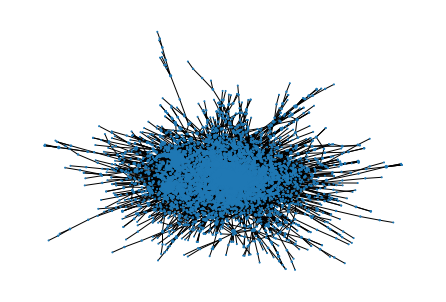

In [24]:
nx.draw(artists_graph, node_size=list(dict(artists_graph.degree()).values()))

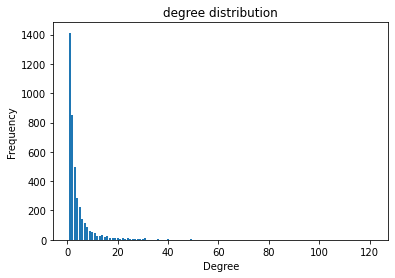

In [67]:
# Plot degree distribution
degree = list(dict(artists_graph.degree()).values())
hist, bin = np.histogram(degree, bins=range(min(degree), max(degree))) # return an array with histogram values and the bin edges 

# f, ax = plt.subplots(1,2, figsize=(15,5))
plt.title('degree distribution')
plt.bar(bin[:-1], hist)
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.show()

Calculating best minimal value for power law fit
The slope of the incoming degree distribution 3.5617373390753584


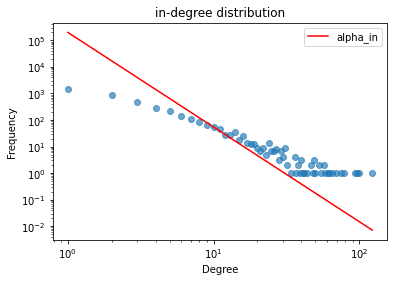

In [68]:
from math import exp
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import powerlaw

degree_sequence = sorted(list(dict(artists_graph.degree()).values()), reverse=True)
alpha_in = powerlaw.Fit(degree_sequence).alpha
print("The slope of the incoming degree distribution", alpha_in)
degree_freq = Counter(degree_sequence)

x = np.log(np.array(list(degree_freq.keys())))
y = np.log(np.array(list(degree_freq.values())))

ymin, ymax = ([0, y.max()])
ymid = (ymin + ymax) / 2
xmin, xmax = ([0, x.max()])
xmid = (xmin + xmax) / 2

y1 = -alpha_in * (xmin - xmid) + ymid
y2 = -alpha_in * (xmax - xmid) + ymid

fig = plt.figure()
ax = plt.gca()
plt.scatter(degree_freq.keys(), degree_freq.values() , alpha=0.65)
ax.plot(np.exp([xmin, xmax]), np.exp([y1, y2]), 'r', label="alpha_in")

plt.title("in-degree distribution")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.loglog()
plt.legend()

In [69]:
from community import community_louvain
# compute the best partition
communities = community_louvain.best_partition(artists_graph, random_state=0) 
# we used random_state parameter so that the results can be reproduced
mod = community_louvain.modularity(communities, artists_graph)
print("modularity is", mod)

no_communities = len(Counter(communities.values()))
print("The Louvain algorithm had found", no_communities, "communities")

for community, count in Counter(communities.values()).most_common():
    print("The community", community, "has", count, "nodes")

modularity is 0.7214146764978137
The Louvain algorithm had found 44 communities
The community 6 has 471 nodes
The community 0 has 371 nodes
The community 34 has 349 nodes
The community 20 has 328 nodes
The community 8 has 208 nodes
The community 9 has 206 nodes
The community 21 has 151 nodes
The community 15 has 151 nodes
The community 7 has 141 nodes
The community 35 has 137 nodes
The community 2 has 135 nodes
The community 5 has 124 nodes
The community 14 has 115 nodes
The community 33 has 112 nodes
The community 19 has 99 nodes
The community 3 has 97 nodes
The community 36 has 89 nodes
The community 29 has 84 nodes
The community 24 has 83 nodes
The community 37 has 73 nodes
The community 28 has 70 nodes
The community 22 has 69 nodes
The community 1 has 63 nodes
The community 27 has 60 nodes
The community 12 has 59 nodes
The community 4 has 58 nodes
The community 23 has 55 nodes
The community 11 has 16 nodes
The community 26 has 16 nodes
The community 39 has 12 nodes
The community 31

100%|██████████| 2000/2000 [02:18<00:00, 14.40it/s]


BarnesHut Approximation  took  53.44  seconds
Repulsion forces  took  78.29  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.44  seconds
AdjustSpeedAndApplyForces step  took  1.83  seconds


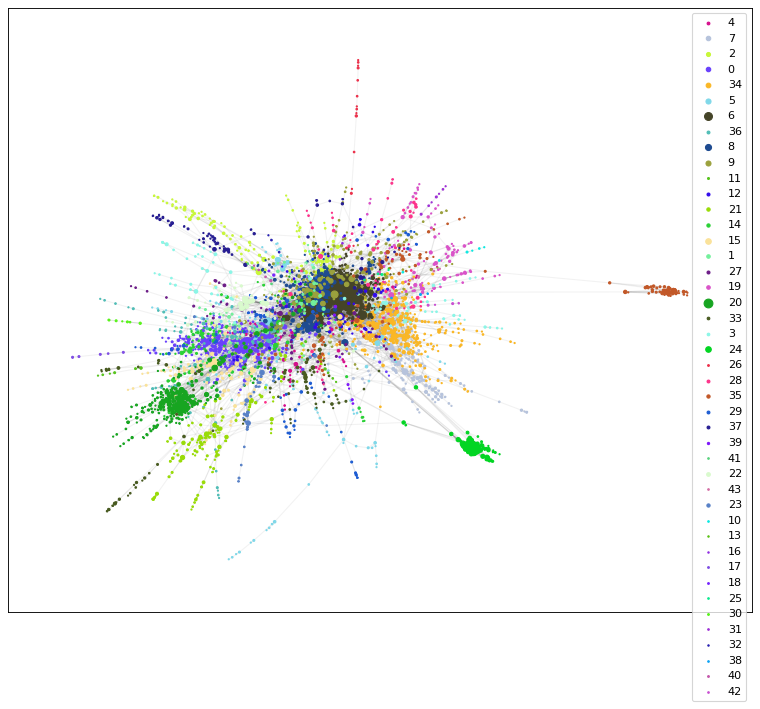

In [70]:
import fa2

forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.9,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=0.6,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(artists_graph, pos=None, iterations=2000)
        
plt.figure(figsize=(12, 10), dpi=80)
communities_color = {} # keep a dict with colors for each community
nodelist_dc = []

for community in  Counter(communities.values()):
    communities_color[community] = np.array([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)])
    nodelist = []
    
    for node in artists_graph:
        if node not in communities:
            nodelist_dc.append(node)
        elif communities[node] == community:
            nodelist.append(node)
    # display nodes from current Marvel's community       
    nx.draw_networkx_nodes(artists_graph,
                           pos=positions,
                           nodelist=nodelist,
                           node_size=list(dict(artists_graph.degree(nodelist)).values()),
                           node_color=communities_color[community].reshape(1,-1), label=community)
nx.draw_networkx_edges(artists_graph, pos=positions, alpha=0.05)
plt.legend()


#### Spotify artists network

##### Generate network

In [71]:
# construct artist network
sp_artists_graph = nx.Graph()
sp_artists_graph.add_nodes_from(artists_set)

In [73]:
for i, artist in artists_df.iterrows():
    if i % 100 == 0:
        # os.system('clear')
        clear_output()
        print(i, "/", len(artists_df))
    if artist.related_artists:
        for collab in artist.related_artists:
            sp_artists_graph.add_edge(artist.artistname, collab)

4800 / 4819


In [75]:
sp_artists_graph.remove_nodes_from(list(nx.isolates(sp_artists_graph)))
Gcc = sorted(nx.connected_components(sp_artists_graph), key=len, reverse=True)
sp_artists_graph = sp_artists_graph.subgraph(Gcc[0])

print("number of nodes:", sp_artists_graph.number_of_nodes())
print("number of edges:", sp_artists_graph.number_of_edges())

number of nodes: 3590
number of edges: 14532


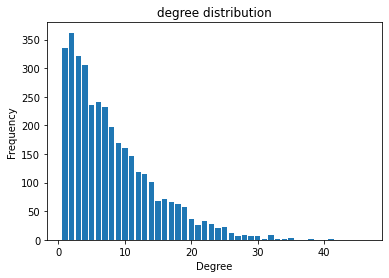

In [78]:
# Plot degree distribution
degree = list(dict(sp_artists_graph.degree()).values())
hist, bin = np.histogram(degree, bins=range(min(degree), max(degree))) # return an array with histogram values and the bin edges 

# f, ax = plt.subplots(1,2, figsize=(15,5))
plt.title('degree distribution')
plt.bar(bin[:-1], hist)
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.show()

Calculating best minimal value for power law fit
The slope of the incoming degree distribution 8.490270677202023


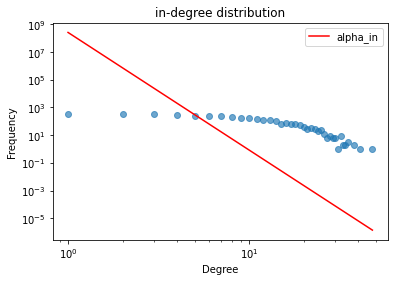

In [79]:
from math import exp
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import powerlaw

degree_sequence = sorted(list(dict(sp_artists_graph.degree()).values()), reverse=True)
alpha_in = powerlaw.Fit(degree_sequence).alpha
print("The slope of the incoming degree distribution", alpha_in)
degree_freq = Counter(degree_sequence)

x = np.log(np.array(list(degree_freq.keys())))
y = np.log(np.array(list(degree_freq.values())))

ymin, ymax = ([0, y.max()])
ymid = (ymin + ymax) / 2
xmin, xmax = ([0, x.max()])
xmid = (xmin + xmax) / 2

y1 = -alpha_in * (xmin - xmid) + ymid
y2 = -alpha_in * (xmax - xmid) + ymid

fig = plt.figure()
ax = plt.gca()
plt.scatter(degree_freq.keys(), degree_freq.values() , alpha=0.65)
ax.plot(np.exp([xmin, xmax]), np.exp([y1, y2]), 'r', label="alpha_in")

plt.title("in-degree distribution")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.loglog()
plt.legend()

##### Spotify network's communities

In [81]:
# compute the best partition
communities = community_louvain.best_partition(sp_artists_graph, random_state=0) 
# we used random_state parameter so that the results can be reproduced
mod = community_louvain.modularity(communities, sp_artists_graph)
print("modularity is", mod)

no_communities = len(Counter(communities.values()))
print("The Louvain algorithm had found", no_communities, "communities")

for community, count in Counter(communities.values()).most_common():
    print("The community", community, "has", count, "nodes")

modularity is 0.8495899834256265
The Louvain algorithm had found 33 communities
The community 0 has 337 nodes
The community 14 has 311 nodes
The community 2 has 238 nodes
The community 6 has 238 nodes
The community 4 has 235 nodes
The community 7 has 200 nodes
The community 9 has 193 nodes
The community 22 has 165 nodes
The community 3 has 162 nodes
The community 1 has 153 nodes
The community 20 has 148 nodes
The community 5 has 140 nodes
The community 10 has 126 nodes
The community 19 has 123 nodes
The community 8 has 120 nodes
The community 11 has 95 nodes
The community 12 has 93 nodes
The community 13 has 85 nodes
The community 18 has 84 nodes
The community 25 has 60 nodes
The community 23 has 48 nodes
The community 21 has 42 nodes
The community 17 has 34 nodes
The community 27 has 31 nodes
The community 30 has 26 nodes
The community 29 has 25 nodes
The community 24 has 15 nodes
The community 26 has 15 nodes
The community 31 has 15 nodes
The community 32 has 11 nodes
The community 1

100%|██████████| 2000/2000 [02:07<00:00, 15.65it/s]


BarnesHut Approximation  took  50.54  seconds
Repulsion forces  took  69.33  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.74  seconds
AdjustSpeedAndApplyForces step  took  1.84  seconds


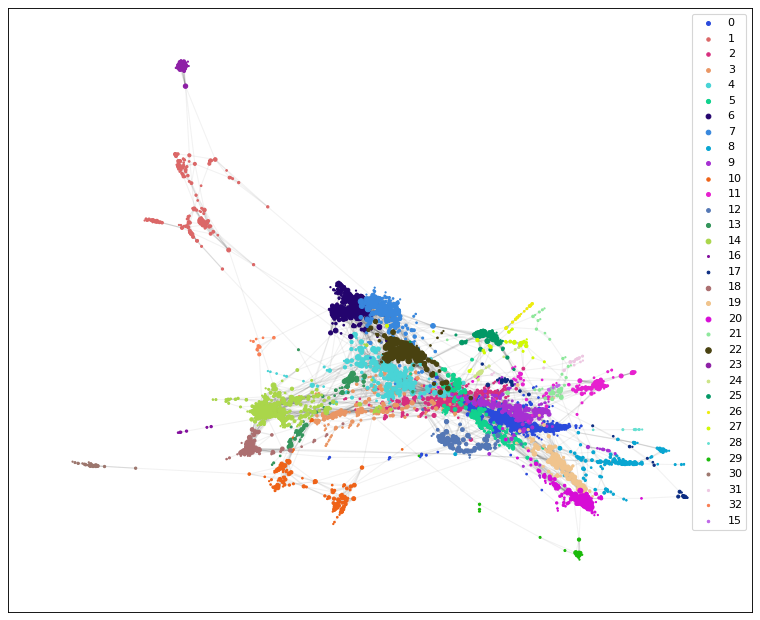

In [82]:
forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.9,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=0.6,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(sp_artists_graph, pos=None, iterations=2000)
        
plt.figure(figsize=(12, 10), dpi=80)
communities_color = {} # keep a dict with colors for each community
nodelist_dc = []

for community in  Counter(communities.values()):
    communities_color[community] = np.array([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)])
    nodelist = []
    
    for node in sp_artists_graph:
        if node not in communities:
            nodelist_dc.append(node)
        elif communities[node] == community:
            nodelist.append(node)
    # display nodes from current Marvel's community       
    nx.draw_networkx_nodes(sp_artists_graph,
                           pos=positions,
                           nodelist=nodelist,
                           node_size=list(dict(sp_artists_graph.degree(nodelist)).values()),
                           node_color=communities_color[community].reshape(1,-1), label=community)
nx.draw_networkx_edges(sp_artists_graph, pos=positions, alpha=0.05)
plt.legend()


In [86]:
# # save network as edge list
# from networkx.readwrite import json_graph
# with open("/content/drive/MyDrive/SocialGraphs/artists_graph.json", "w") as outfile:
#     outfile.write(json.dumps(json_graph.node_link_data(artists_graph)))
# with open("/content/drive/MyDrive/SocialGraphs/sp_artists_graph.json", "w") as outfile:
#     outfile.write(json.dumps(json_graph.node_link_data(sp_artists_graph)))

## Compute the users dataframe:

In [87]:
users_set = set(spotify_df.user_id)
len(users_set)

15279

In [ ]:
users_tracks_dict = dict((k, set()) for k in users_set)
users_artists_dict = dict((k, set()) for k in users_set)
i = 0
for _, entry in spotify_df.iterrows():
    if i % 100000 == 0:
        print(i, "/", len(spotify_df))
    i+=1
    users_tracks_dict[entry.user_id].add((entry.trackname, ", ".join(entry.artistname)))
    for artist in entry.artistname:
        users_artists_dict[entry.user_id].add(artist)

In [89]:
# Create users dataframe
data = {'user_id': list(users_set),
        'tracks': list(users_tracks_dict.values()),
        'artists': list(users_artists_dict.values())}
users_df = pd.DataFrame(data)
users_df.head() 

,user_id,tracks,artists
0,8a6af823df9ff52ad1eea2219812b30d,"{(Don't Leave Your Mark On Me, meat loaf), (Tr...","{iii, metallica, eric clapton, nine inch nails..."
1,deae855daeb74bc8284172dcc3fd78df,{(The Christmas Song (Chestnuts Roasting On An...,"{jim jones, kato, guilty simpson, megadeth, me..."
2,8d59c09f4c5a8e91a7ab850a231ed686,"{(Rude Boy, rihanna), (Cancioncitas de Amor, r...","{ana torroja, tamara, omega, ariana grande, do..."
3,706a25c6cba55357d87620af5c2e3c5e,"{(All You Ever Wanted, the black keys), (I Pre...","{big pun, dr dre, kaiser chiefs, flo rida, fra..."
4,bfabf15d1188c19144762cce8338387e,"{(The Number Song - Cut Chemist Remix, dj shad...","{dj shadow, fall out boy, ben folds}"


In [90]:
# users_df.to_pickle(r'/content/drive/MyDrive/SocialGraphs/users_dataset.pickle')

In [5]:
users_df = pd.read_pickle(r'/content/drive/MyDrive/SocialGraphs/users_dataset.pickle')  

##### Create tracks dataset:

In [41]:
tracks = set([track for tracks in users_df.tracks for track in tracks])
len(tracks)

409834

In [42]:
data = {'trackname': list(tracks),
        'lyrics': [None] * len(tracks)}
tracks_df = pd.DataFrame(data)

tracks_df.to_pickle(r'/content/drive/MyDrive/SocialGraphs/tracks_dataset.pickle')

#### Users' tracks number distribution

In [ ]:
# Users number of songs
users_tracks_no = Counter({k: len(v) for k, v in users_tracks_dict.items()})

values = list(users_tracks_no.values())
hist, bin = np.histogram(values, bins=range(min(values), max(values))) # return an array with histogram values and the bin edges 

print(np.mean(list(users_tracks_no.values())))
print(np.std(list(users_tracks_no.values())))


plt.figure(figsize=(15, 5))
plt.title('Users number of tracks distribution')
plt.bar(bin[:-1], hist, width=bin[1]-bin[0], ec='k', lw=1)
plt.xlabel("Number of tracks")
plt.ylabel("Frequency")

plt.show()

In [32]:
users_tracks_no.most_common()[-10:-1]

[('81dfc71be6029fba8762b6603b465bea', 1),
 ('8f6956c2246cfbd556bb1995b62d0e66', 1),
 ('ecc01981ba54548379f48bc1d86ed2ac', 1),
 ('92946c35bc78e7482c24cc81e53f9b6c', 1),
 ('4b2429013cfdd54b1fa6d0840e9c6e2f', 1),
 ('a28a6cd013f214032074ca1079dca1ee', 1),
 ('a6b7ec7880c8d76b205c6b49f8689430', 1),
 ('c37e63d7dbff89c681f8583e9201e272', 1),
 ('a8e2bada1251d231b77372eeb758d729', 1)]

Since, the resulted users network whould have been to large if we consider all users from the `spotify_df`, we elliminated accounts where the number of listening song is higher than 10000 and lower than 100.

In [49]:
idx_list = []
for idx, entry in users_df.iterrows():
    if len(entry.tracks) < 100 or len(entry.tracks) > 500:
        idx_list.append(idx)
users_df.drop(idx_list, axis=0, inplace=True)
len(users_df)

6614

### Create users network

In [51]:
users = users_df.user_id
users_graph = nx.Graph()
users_graph.add_nodes_from(users)

In [52]:
len(set(spotify_df.trackname))

522280

In [53]:
visited = set()
i = 0
for _, user_A in users_df.iterrows():
    if i % 100==0:
        clear_output()
        print(i, "/", len(users_df), users_graph.number_of_edges())
    i+=1
    visited.add(user_A.user_id)
    for _, user_B in users_df.iterrows():
        if user_B.user_id not in visited:
            if (user_A.tracks & user_B.tracks):
                users_graph.add_edge(user_A.user_id, user_B.user_id)

6600 / 6614 12784344


In [54]:
users_graph.remove_nodes_from(list(nx.isolates(users_graph)))
Gcc = sorted(nx.connected_components(users_graph), key=len, reverse=True)
users_graph = users_graph.subgraph(Gcc[0])
print("number of nodes:", users_graph.number_of_nodes())
print("number of edges:", users_graph.number_of_edges())

number of nodes: 6614
number of edges: 12784407


In [ ]:
# compute the best partition
communities = community_louvain.best_partition(users_graph, random_state=0) 
# we used random_state parameter so that the results can be reproduced
mod = community_louvain.modularity(communities, users_graph)
print("modularity is", mod)

no_communities = len(Counter(communities.values()))
print("The Louvain algorithm had found", no_communities, "communities")

for community, count in Counter(communities.values()).most_common():
    print("The community", community, "has", count, "nodes")

In [ ]:
from networkx.readwrite import json_graph
with open("/content/drive/MyDrive/SocialGraphs/users_graph.json", "w") as outfile:
    outfile.write(json.dumps(json_graph.node_link_data(users_graph)))